In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
df=pd.read_csv(r"E:\10.python\Time Series\1\ARIMA-And-Seasonal-ARIMA\perrin-freres-monthly-champagne-.csv")
df

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946
...,...,...
100,1972-05,4618
101,1972-06,5312
102,1972-07,4298
103,1972-08,1413


In [83]:
df.columns=["Month","Sales"]

<AxesSubplot:>

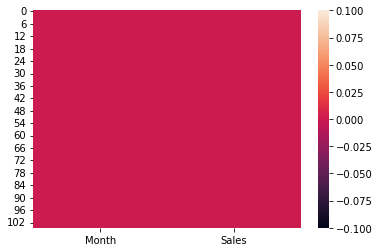

In [84]:
sns.heatmap(df.isnull())

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [86]:
df["Month"]=pd.to_datetime(df["Month"])

In [87]:
df.sort_values("Month",inplace=True)

In [88]:
df.set_index("Month",inplace=True)

In [89]:
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [90]:
from statsmodels.tsa.stattools import adfuller

In [91]:
result=adfuller(df["Sales"])

In [92]:
if result[1]>0.05:
    print('Not much evidance to reject null hypothesis >> it is non staionary',round(result[1],2))
else:
    print("Reject the null hypothesis >> it is staionary",round(result[1],2))

Not much evidance to reject null hypothesis >> it is non staionary 0.36


In [93]:
df

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


p-value = 2.51962044738698e-10 The series is likely stationary.
Test Statistic                -7.189896e+00
p-value                        2.519620e-10
#Lags Used                     1.100000e+01
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


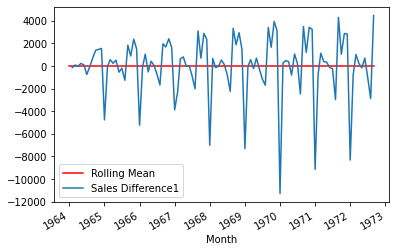

In [94]:
def Differencing(df,target,cutoff=0.05):
    df1=df.copy()
    from statsmodels.tsa.stattools import adfuller
    for i in range(1,df1.shape[0]):
        df1['Sales Difference'+str(i)] = df1[target] - df1[target].shift(i)
        result=adfuller(df1['Sales Difference'+str(i)].dropna())
        df1["mean"] = df1['Sales Difference'+str(i)].mean()
        dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in result[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        pvalue = result[1]
        if pvalue < cutoff:
            print(f'p-value = {pvalue} The series is likely stationary.')
            print(dfoutput)
            mean = plt.plot(df1["mean"] , color='red', label='Rolling Mean')
            df1['Sales Difference'+str(i)].plot()
            plt.legend()
#             print(df1)
            break
        else:
            pass
    else:
        print(f'p-value = {pvalue} The series is likely non-stationary.')
Differencing(df,"Sales")    

In [95]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [100]:
df['Seasonal First Difference']=df["Sales"] - df["Sales"].shift(12)

C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


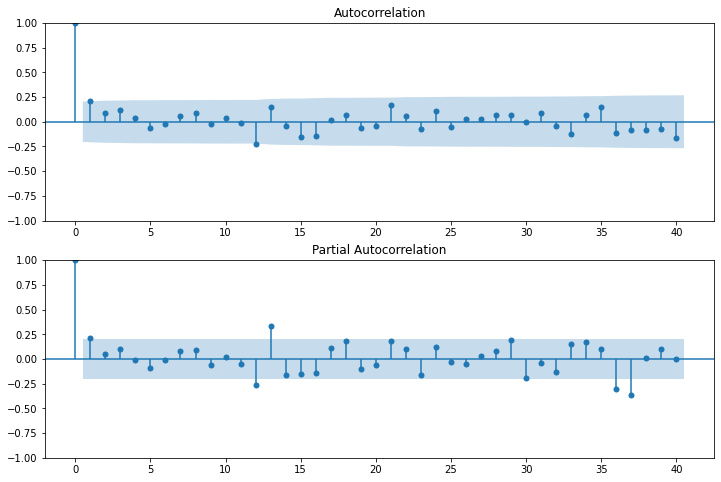

In [103]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [105]:
# For non-seasonal data
#p=0, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA 

In [106]:
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()

C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

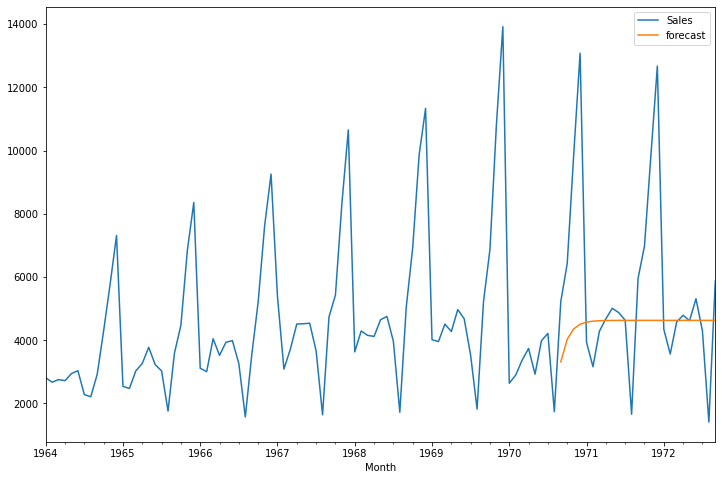

In [107]:
df['forecast']=model_fit.predict(start=80,end=105,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [108]:
import statsmodels.api as sm

In [109]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\91703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

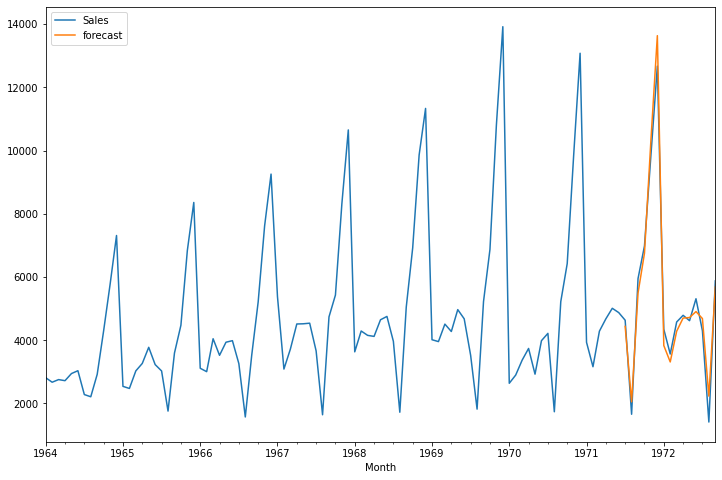

In [117]:
df['forecast']=results.predict(start=90,end=105,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [120]:
def future_date(next_date=12):
    from pandas.tseries.offsets import DateOffset
    future_dates=[df.index[-1]+ DateOffset(months=x) for x in range(0,next_date)]
    future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
    future_df=pd.concat([df,future_datest_df])
    return future_df
future_df=future_date(next_date=24)

In [121]:
future_df

,Sales,Seasonal First Difference,forecast
1964-01-01,2815,NaN,NaN
1964-02-01,2672,NaN,NaN
1964-03-01,2755,NaN,NaN
1964-04-01,2721,NaN,NaN
1964-05-01,2946,NaN,NaN
...,...,...,...
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN


<AxesSubplot:>

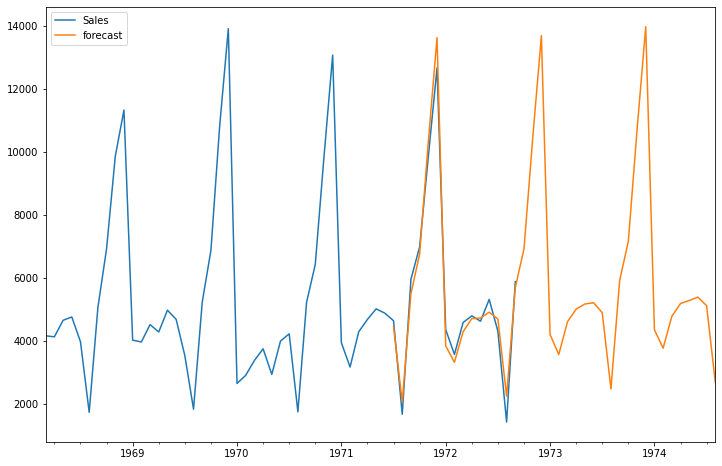

In [122]:
future_df['forecast'] = results.predict(start = 90, end = 130, dynamic= True)  
future_df[['Sales', 'forecast']].iloc[50:,:].plot(figsize=(12, 8)) 